### 作業
請嘗試使用 keras 來定義一個直接預測 15 個人臉關鍵點坐標的檢測網路，以及適合這個網路的 loss function


Hint: 參考前面的電腦視覺深度學習基礎

### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

# Training Data
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1G2vAU07RlFc9_bTMY9WSAlx9GdsS6ALY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1G2vAU07RlFc9_bTMY9WSAlx9GdsS6ALY" -O training.zip && rm -rf /tmp/cookies.txt
# !unzip training
# Testing Data
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jnbxTisefsT6pTnrVkigngG_OUdPUot_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jnbxTisefsT6pTnrVkigngG_OUdPUot_" -O test.zip && rm -rf /tmp/cookies.txt  

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    #points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
imgs_train = np.expand_dims(imgs_train, axis=3)
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96, 1) 
關鍵點資料: (2140, 30)


In [5]:
validation = imgs_train.shape[0]//20
imgs_val = imgs_train[:validation]
imgs_train = imgs_train[validation:]
points_val = points_train[:validation]
points_train = points_train[validation:]
print("Training Images:", imgs_train.shape, "\nTraining Points:", points_train.shape)
print("Validation Images:", imgs_val.shape, "\nValidation Points:", points_val.shape)

Training Images: (2140, 96, 96, 1) 
Training Points: (2140, 30)
Validation Images: (0, 96, 96, 1) 
Validation Points: (0, 30)


In [6]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from keras.models import Sequential
from keras import layers, Input
from keras.models import Model
from keras.layers import Conv2D, Dense, BatchNormalization, LeakyReLU, MaxPooling2D, Flatten, Dropout

Using TensorFlow backend.


In [7]:
from keras.optimizers import Adam

model = Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Conv2D(32, (3,3), padding='same', use_bias=True, input_shape=(96,96,1)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
# Input dimensions: (None, 96, 96, 32)
model.add(Conv2D(32, (3,3), padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Input dimensions: (None, 48, 48, 32)
model.add(Conv2D(64, (3,3), padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
# Input dimensions: (None, 48, 48, 64)
model.add(Conv2D(64, (3,3), padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Conv2D(96, (3,3), padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
# Input dimensions: (None, 24, 24, 96)
model.add(Conv2D(96, (3,3), padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Input dimensions: (None, 12, 12, 96)
model.add(Conv2D(128, (3,3),padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
# Input dimensions: (None, 12, 12, 128)
model.add(Conv2D(128, (3,3),padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Input dimensions: (None, 6, 6, 128)
model.add(Conv2D(256, (3,3),padding='same',use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
# Input dimensions: (None, 6, 6, 256)
model.add(Conv2D(256, (3,3),padding='same',use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Conv2D(512, (3,3), padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
# Input dimensions: (None, 3, 3, 512)
model.add(Conv2D(512, (3,3), padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

adam = Adam(lr=1e-4, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'acc'])








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0        

In [8]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

In [9]:
def point2tuple(keypoints):
    a = []
    for idx in range(0, len(keypoints), 2):
        a.append((keypoints[idx], keypoints[idx+1]))
    return a

In [10]:
# import albumentations as albu

# def create_transformer(transformations, image, points):
#     return albu.Compose(transformations, p=1, 
#                         keypoint_params=albu.KeypointParams(format='xy'))(image=image, keypoints=points)

# def scale_augmentation(images, keypoints):
    
#     scale_images = []
#     scale_keypoints = []
    
#     for idx in range(len(imgs_train)):
#         image = imgs_train[idx]
#         keypoints = point2tuple(points_train[idx])
#         transformed = create_transformer([albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,
#                                                                 rotate_limit=0, interpolation=2,
#                                                                 border_mode=4, always_apply=True)],
#                                          image.reshape(96,96), keypoints)
        
#         if len(transformed['keypoints']) == 15:
#             scale_images.append(transformed['image'].reshape(96,96,1))
#             scale_keypoints.append(np.array(transformed['keypoints']).reshape(30,))
        
#     return np.reshape(scale_images,(-1,96,96,1)), scale_keypoints
    
# scale_train_images, scale_train_keypoints = scale_augmentation(imgs_train, points_train)
# print("\nShape of scaled_train_images: {}".format(np.shape(scale_train_images)))
# print("Shape of scaled_train_keypoints: {}\n".format(np.shape(scale_train_keypoints)))
# imgs_train = np.concatenate((imgs_train, scale_train_images))
# points_train = np.concatenate((points_train, scale_train_keypoints))
# print("Total training images:", imgs_train.shape[0])
# print("Total training keypoints:", points_train.shape[0])

# sample_image_index = 20
# fig, axis = plt.subplots()
# plot_sample(scale_train_images[sample_image_index], scale_train_keypoints[sample_image_index], axis, "Scale Augmentation")

Augmenting for angles (in degrees): 
5  -5  10  -10  15  -15  20  -20  25  -25  30  -30  
Shape of rotated_train_images: (25680, 96, 96, 1)
Shape of rotated_train_keypoints: (25680, 30)

Total training images: 27820
Total training keypoints: 27820


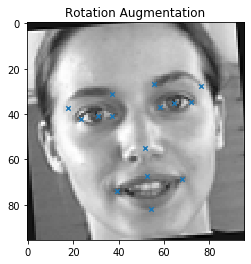

In [11]:
import cv2
from math import pi, cos, sin
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in [5,10,15,20,25,30]:    # Rotation augmentation for a list of angle values
        for angle in [angle, -angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC, borderValue=10)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints


rotated_train_images, rotated_train_keypoints = rotate_augmentation(imgs_train, points_train)
print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
imgs_train = np.concatenate((imgs_train, rotated_train_images))
points_train = np.concatenate((points_train, rotated_train_keypoints))
print("Total training images:", imgs_train.shape[0])
print("Total training keypoints:", points_train.shape[0])

sample_image_index = 20
fig, axis = plt.subplots()
plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

Shape of flipped_train_images: (27820, 96, 96, 1)
Shape of flipped_train_keypoints: (27820, 30)
Total training images: 55640
Total training keypoints: 55640


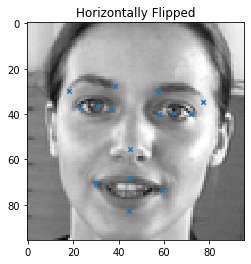

In [12]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints


flipped_train_images, flipped_train_keypoints = left_right_flip(imgs_train, points_train)
print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
imgs_train = np.concatenate((imgs_train, flipped_train_images))
points_train = np.concatenate((points_train, flipped_train_keypoints))
print("Total training images:", imgs_train.shape[0])
print("Total training keypoints:", points_train.shape[0])

fig, axis = plt.subplots()
plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

In [13]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

lr_reducer = ReduceLROnPlateau(monitor='val_mean_absolute_error',
                               factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6,
                               verbose=1)

checkpoint = ModelCheckpoint(filepath = 'Face_model_Cutout_{epoch:03d}_{mean_absolute_error:.2f}.h5', monitor='mean_absolute_error', verbose=1, save_best_only=True, period=5)


def lr_scheduler(epoch, lr):
    if epoch < 10:
        lr = 1e-3
    elif epoch % 10 ==0:
        lr = lr*np.sqrt(0.1)


    print('lr: %f' % lr)
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa

augmentation = iaa.Sequential([
    # Strengthen or weaken the contrast in each image.
    iaa.Sometimes(0.3, iaa.Cutout(nb_iterations=1, size=[0.2], squared=False, cval=(0, 255)))

    ], random_order=True) # apply augmenters in random order    


train_datagen=ImageDataGenerator(preprocessing_function=augmentation.augment_image, rescale=1./255)

train_generator=train_datagen.flow(imgs_train, 
                                   points_train,
                                   batch_size=256,
                                   shuffle=True)

val_datagen=ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(imgs_val, points_val, batch_size=256)


history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs=71, verbose=1, workers=1,
                              use_multiprocessing=False, callbacks=[lr_reducer, checkpoint])

Epoch 1/71
lr: 0.001000
218/218 [==============================] - 41s 188ms/step - loss: 198.7300 - mean_absolute_error: 10.0230 - acc: 0.3288
Epoch 2/71
lr: 0.001000
218/218 [==============================] - 37s 170ms/step - loss: 35.6846 - mean_absolute_error: 3.9179 - acc: 0.6114
Epoch 3/71
lr: 0.001000
218/218 [==============================] - 37s 170ms/step - loss: 20.0284 - mean_absolute_error: 3.0785 - acc: 0.6740
Epoch 4/71
lr: 0.001000
218/218 [==============================] - 37s 170ms/step - loss: 15.5564 - mean_absolute_error: 2.7233 - acc: 0.7050
Epoch 5/71
lr: 0.001000
218/218 [==============================] - 37s 172ms/step - loss: 13.3009 - mean_absolute_error: 2.5414 - acc: 0.7254

Epoch 00005: mean_absolute_error improved from inf to 2.54103, saving model to Face_model_Cutout_005_2.54.h5
Epoch 6/71
lr: 0.001000
218/218 [==============================] - 37s 170ms/step - loss: 11.9678 - mean_absolute_error: 2.3943 - acc: 0.7432
Epoch 7/71
lr: 0.001000
218/218 [===

Epoch 51/71
lr: 0.000003
218/218 [==============================] - 37s 171ms/step - loss: 4.0113 - mean_absolute_error: 1.5377 - acc: 0.8483
Epoch 52/71
lr: 0.000003
218/218 [==============================] - 37s 171ms/step - loss: 4.0012 - mean_absolute_error: 1.5348 - acc: 0.8505
Epoch 53/71
lr: 0.000003
218/218 [==============================] - 37s 171ms/step - loss: 4.0137 - mean_absolute_error: 1.5363 - acc: 0.8497
Epoch 54/71
lr: 0.000003
218/218 [==============================] - 37s 172ms/step - loss: 3.9777 - mean_absolute_error: 1.5318 - acc: 0.8499
Epoch 55/71
lr: 0.000003
218/218 [==============================] - 37s 170ms/step - loss: 4.0021 - mean_absolute_error: 1.5336 - acc: 0.8496

Epoch 00055: mean_absolute_error improved from 1.53726 to 1.53367, saving model to Face_model_Cutout_055_1.53.h5
Epoch 56/71
lr: 0.000003
218/218 [==============================] - 37s 171ms/step - loss: 4.0063 - mean_absolute_error: 1.5354 - acc: 0.8492
Epoch 57/71
lr: 0.000003
218/218 [

In [16]:
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.python.keras.utils.data_utils import Sequence
# import sklearn
# import albumentations

# AUGMENTATIONS = albumentations.Compose([
#     albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=False, always_apply=True, p=0)])

# class Sequence(Sequence):
#     def __init__(self, x_set, y_set, batch_size, augmentations, shuffle=True):
#         self.x, self.y = x_set/255, y_set
#         self.batch_size = batch_size
#         self.augment = augmentations
#         self.shuffle = True

#     def __len__(self):
#         return int(np.ceil(len(self.x) / float(self.batch_size)))
    

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         new_images = np.stack([self.augment(image=x)["image"] for x in batch_x], axis=0)
#         new_labels = np.array(batch_y)
#         new_images, new_labels = sklearn.utils.shuffle(new_images,new_labels)
#         return new_images, new_labels
    
# imgs_train, points_train = sklearn.utils.shuffle(imgs_train, points_train)
# train_gen = Sequence(imgs_train, points_train, 256, augmentations=AUGMENTATIONS, shuffle=True)
# train_gen.flow()

# val_datagen=ImageDataGenerator(rescale=1./255)
# val_generator = val_datagen.flow(imgs_val, points_val, batch_size=256)

# model.fit_generator(generator=train_gen,
#                     validation_data=val_generator,
#                     epochs=200, verbose=1, workers=1,
#                     use_multiprocessing=False, callbacks=[lr_reducer])

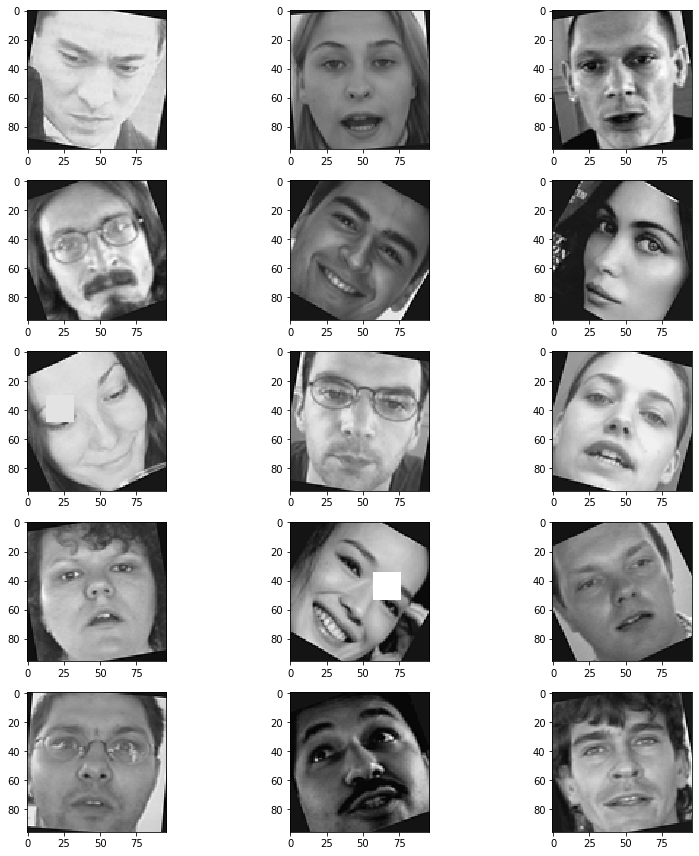

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0].reshape(96,96)
        plt.imshow(image, cmap='gray')
        break
plt.tight_layout()
plt.show()

In [20]:
test_file = 'test.csv'
idlookup_file = 'IdLookupTable.csv'
test_data = pd.read_csv(test_file)
idlookup_data = pd.read_csv(idlookup_file)

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

Shape of test_images: (1783, 96, 96, 1)


In [25]:
from keras.models import load_model 
model = load_model('Face_model_Cutout_065_1.53.h5')
test_preds = model.predict(test_images)

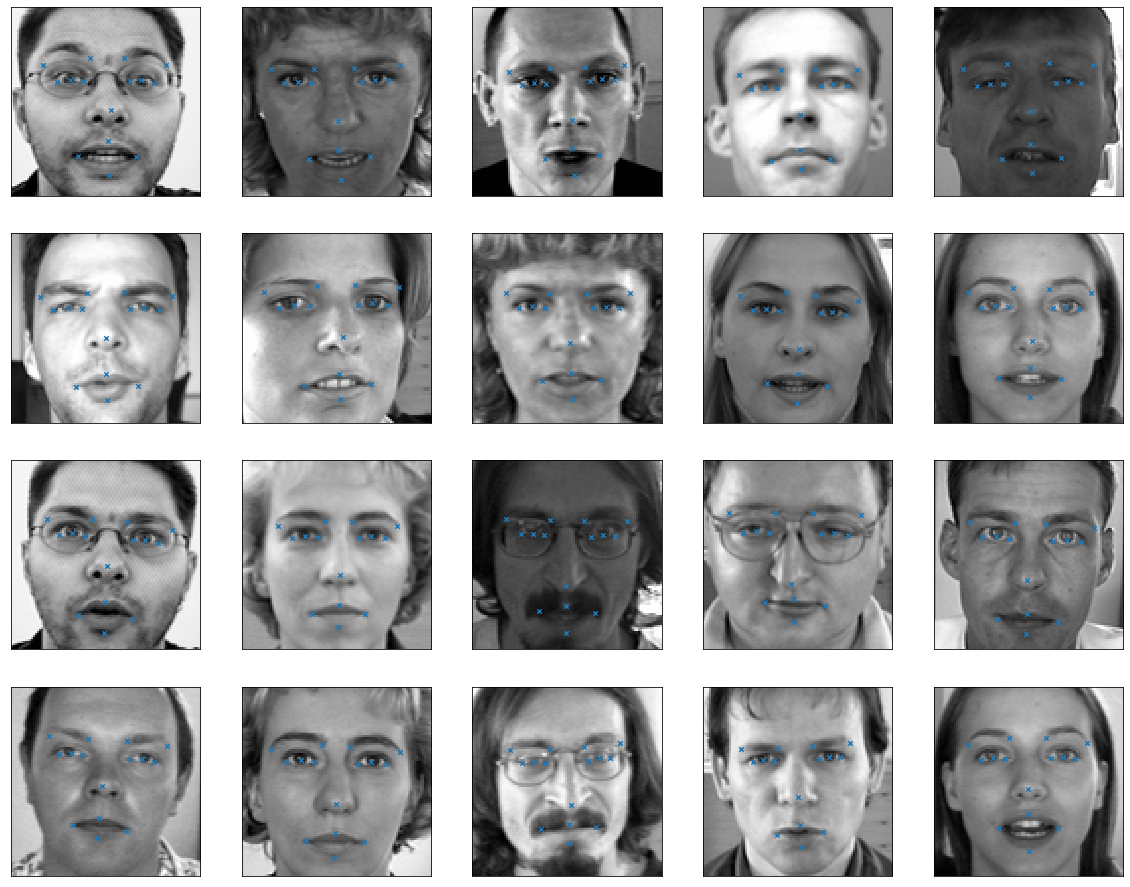

In [27]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")
plt.show()

In [26]:
feature_names = list(idlookup_data['FeatureName'])
image_ids = list(idlookup_data['ImageId']-1)
row_ids = list(idlookup_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('65_1.csv',index = False)